In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [70]:
# Carga de datos y serie univariante
df_imp = pd.read_csv('../data/importacion.csv', parse_dates=['Fecha'], dayfirst=True)
df_imp.set_index('Fecha', inplace=True)
ts_super = df_imp['Gasolina superior']


# Importacion Gasolina Superior

In [18]:
# Inicio, fin y frecuencia
print("Inicio:", ts_super.index.min())
print("Fin:   ", ts_super.index.max())
print("Frecuencia inferida:", pd.infer_freq(ts_super.index))

Inicio: 2001-01-01 00:00:00
Fin:    2024-01-12 00:00:00
Frecuencia inferida: None


# Gráfico de la serie y análisis visual

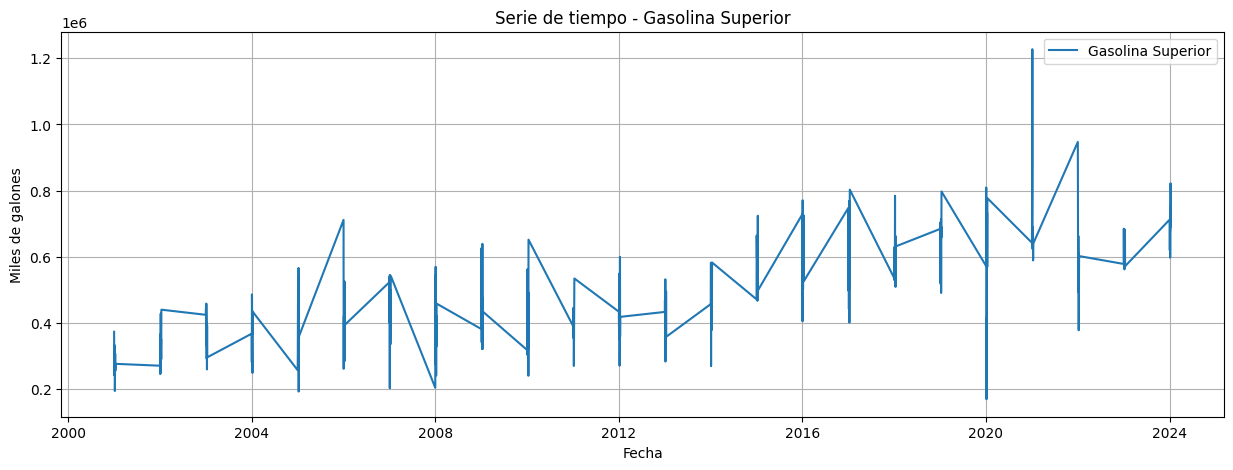

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(ts_super, label='Gasolina Superior')
plt.title("Serie de tiempo - Gasolina Superior")
plt.ylabel("Miles de galones")
plt.xlabel("Fecha")
plt.grid(True)
plt.legend()
plt.show()


# Descomposición y estacionariedad visual

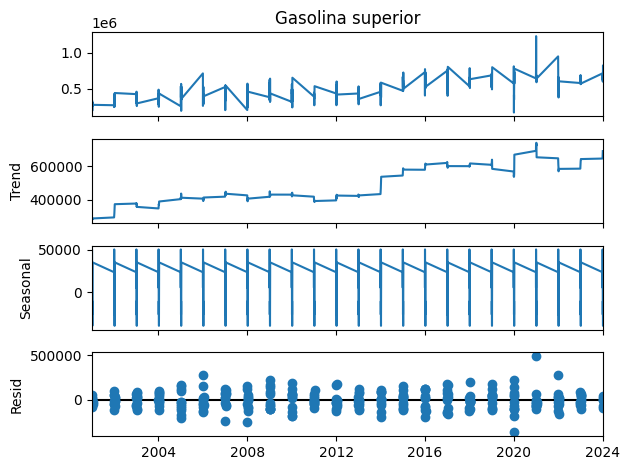

In [23]:
decomp = seasonal_decompose(ts_super, model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.show()


* Componente de la Serie Original (arriba):
Se observa una tendencia ligeramente creciente en el consumo de gasolina superior desde 2003 hasta aproximadamente 2023.

Hay una alta variabilidad mes a mes, con algunos picos abruptos (por ejemplo, alrededor de 2020), que podrían estar relacionados con eventos extraordinarios como la pandemia.

* Tendencia:
La tendencia es suave y creciente, con algunos periodos de estabilización o caídas temporales.

Se nota una aceleración en el crecimiento alrededor de 2015, con cierto estancamiento o leve caída después de 2020, posiblemente influenciado por la crisis sanitaria global.

* Estacionalidad:
La estacionalidad es clara y constante en amplitud y patrón: hay un ciclo anual repetitivo (picos y valles similares cada año).

El patrón estacional indica que ciertos meses del año consistentemente tienen mayor o menor consumo (posiblemente debido a periodos vacacionales, cosechas, turismo, etc.).

* Residuos:
Los residuos están centrados en cero, pero su dispersión varía a lo largo del tiempo, lo que sugiere que la varianza no es completamente constante.

Hay valores atípicos visibles, especialmente durante y después de 2020, lo que sugiere perturbaciones externas importantes en la serie (como la pandemia del COVID-19).

# ¿Es necesario transformar la serie?

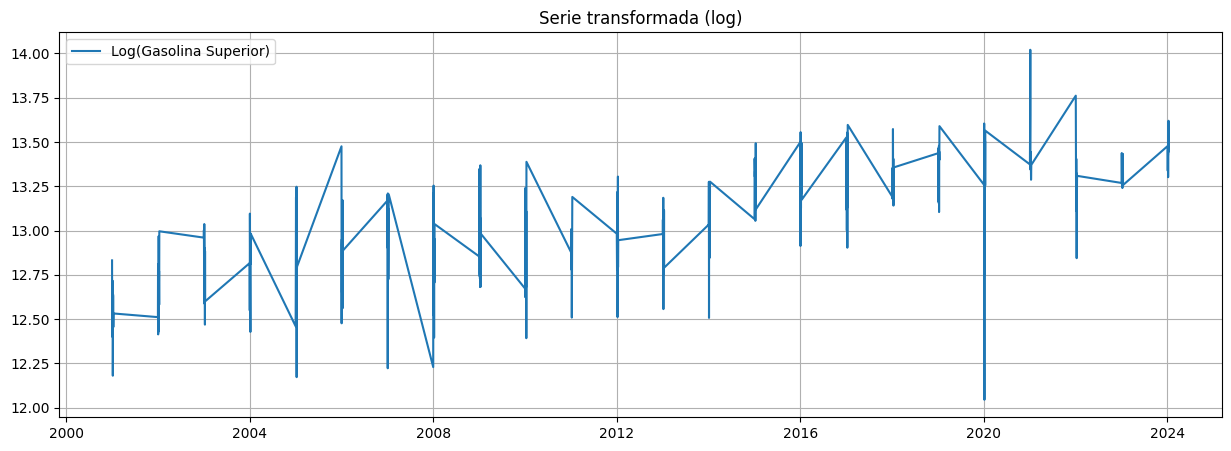

In [26]:
# Comprobación de varianza
ts_super_log = np.log(ts_super)

plt.figure(figsize=(15,5))
plt.plot(ts_super_log, label='Log(Gasolina Superior)')
plt.title("Serie transformada (log)")
plt.grid(True)
plt.legend()
plt.show()


* La serie muestra una tendencia creciente más suavizada en comparación con la serie original.

* La amplitud de las fluctuaciones parece más uniforme, especialmente en los últimos años, lo cual indica que la transformación sí ayuda a reducir la heterocedasticidad (varianza no constante).

* Aunque aún existen picos (como el de 2020), estos están menos acentuados que en la escala original.

# Estacionariedad en media

## Gráfico de autocorrelación

In [31]:
ts_super_diff = ts_super.diff().diff()
ts_super_diff.dropna(inplace = True)
tsa_acf = acf(ts_super_diff,nlags=5,fft=False)
tsa_pacf = pacf(ts_super_diff, nlags=36)
tsa_acf

array([ 1.        , -0.7789213 ,  0.42254069, -0.25461914,  0.20451457,
       -0.17466037])

In [32]:
tsa_pacf

array([ 1.        , -0.78165436, -0.47675927, -0.46175098, -0.32775963,
       -0.3520044 , -0.24963629, -0.19059403, -0.2221062 , -0.27887821,
       -0.37399947, -0.34927268, -0.5971794 , -1.48014472,  2.82137121,
        0.72257719,  0.42205453,  0.4001957 ,  0.36187453,  0.35781667,
        0.4079388 ,  0.4523418 ,  0.6916634 ,  2.19741535, -1.79835944,
       -0.66748806, -0.44037508, -0.46526349, -0.34621914, -0.39052702,
       -0.25603779, -0.343366  , -0.74470629, -2.63380674,  1.59010957,
        0.64081105,  0.40554473])

## acf

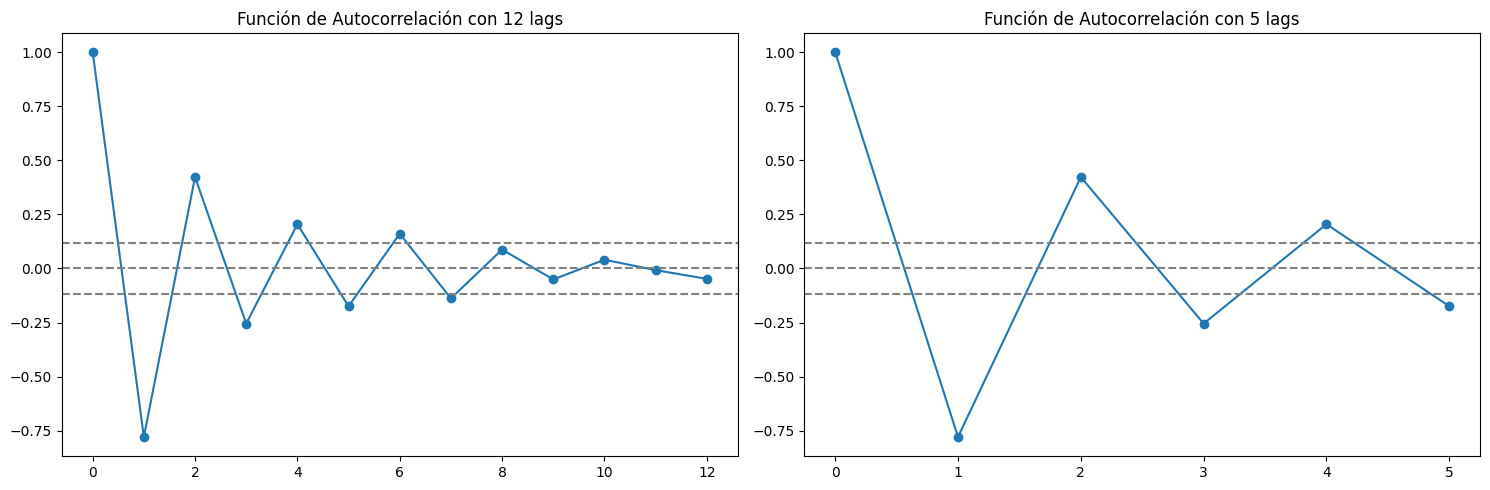

In [34]:
# Configuración del tamaño de las gráficas
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

# Calcular ACF con distintos lags
acf_12 = acf(ts_super_diff, nlags=12, fft=False)
acf_5 = acf(ts_super_diff, nlags=5, fft=False)

# --- Gráfico ACF con 12 lags ---
plt.subplot(121)
plt.plot(acf_12, marker='o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_super_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_super_diff)), linestyle='--', color='gray')
plt.title('Función de Autocorrelación con 12 lags')

# --- Gráfico ACF con 5 lags ---
plt.subplot(122)
plt.plot(acf_5, marker='o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_super_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_super_diff)), linestyle='--', color='gray')
plt.title('Función de Autocorrelación con 5 lags')

plt.tight_layout()
plt.show()

## pacf

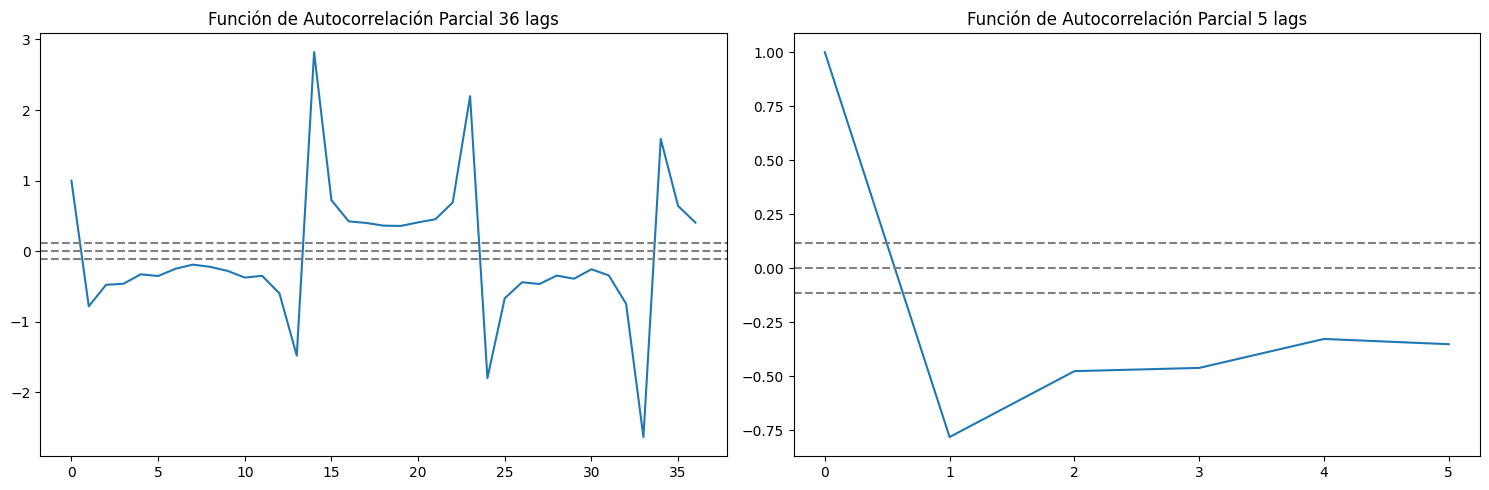

In [40]:
# Configuración de la figura
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

# Cálculo de PACF
pacf_36 = pacf(ts_super_diff, nlags=36, method='ywm')
pacf_5 = pacf(ts_super_diff, nlags=5, method='ywm')

# --- Gráfico PACF con 36 lags ---
plt.subplot(121)
plt.plot(pacf(ts_super_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_super_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_super_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

# --- Gráfico PACF con 5 lags ---
plt.subplot(122)
plt.plot(pacf(ts_super_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_super_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_super_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.tight_layout()
plt.show()


# Dickey-Fuller aumentada (ADF)

In [41]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_super_diff, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba       -8.877401e+00
p-value                      1.346331e-14
# de retardos usados         1.600000e+01
# de observaciones usadas    2.690000e+02
Critical Value (1%)         -3.454896e+00
Critical Value (5%)         -2.872345e+00
Critical Value (10%)        -2.572528e+00
dtype: float64


In [44]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_super_diff = ts_super_diff.diff()
ts_super_diff.dropna(inplace=True)
dfTest = adfuller(ts_super_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -1.027382e+01
p-value                      3.937933e-18
# de retardos usados         1.600000e+01
# de observaciones usadas    2.680000e+02
Critical Value (1%)         -3.454988e+00
Critical Value (5%)         -2.872386e+00
Critical Value (10%)        -2.572549e+00
dtype: float64


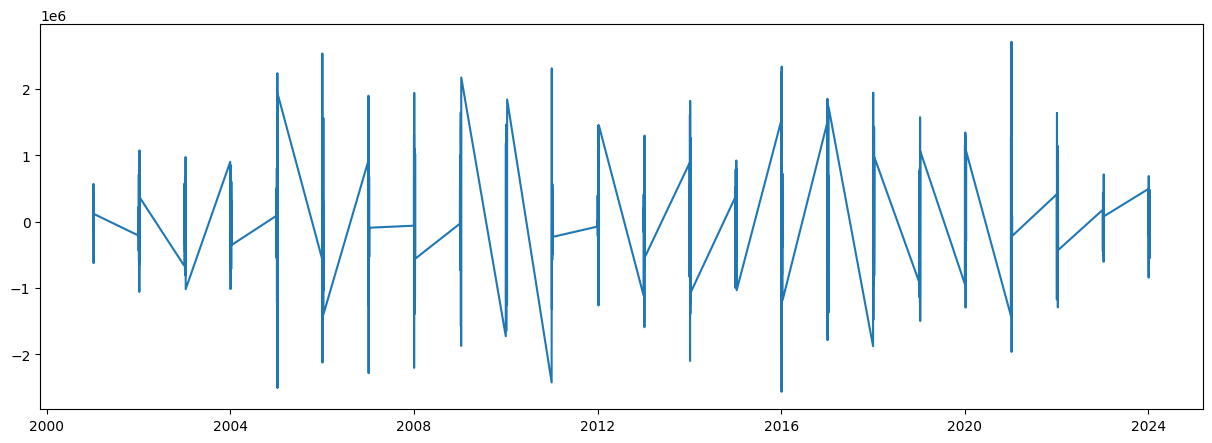

In [46]:
plt.plot(ts_super_diff)

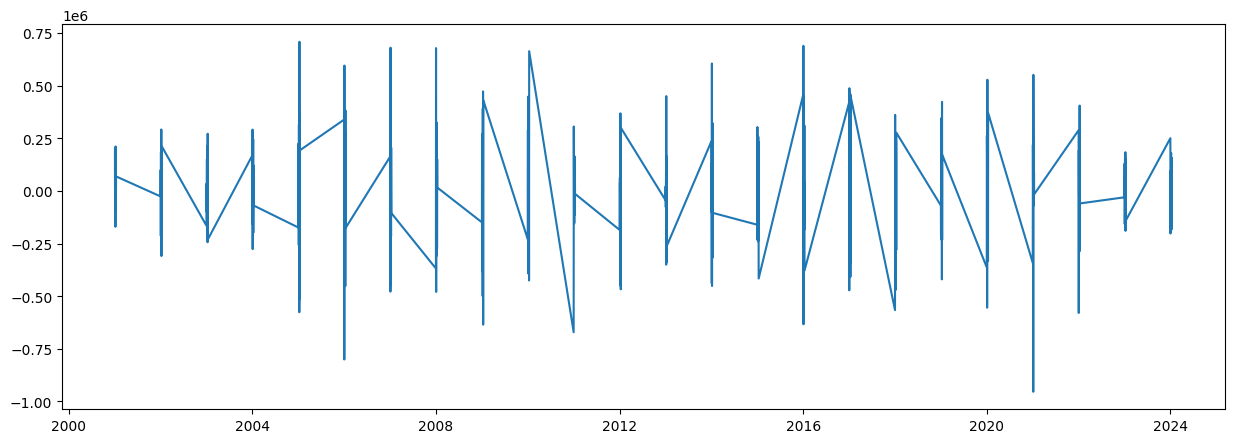

In [48]:
plt.plot(ts_super.diff().diff())

## ACF (Función de Autocorrelación)
El rezago 1 es muy alto y significativo, luego cae abruptamente.

Hay un comportamiento que sugiere autocorrelación positiva en el rezago 2 y más débil en otros.

La ACF se corta rápidamente después del segundo rezago (indicio de un proceso tipo MA).

* La ACF muestra un corte claro a los primeros 1 o 2 rezagos → q = 1 o q = 2.

# PACF (Función de Autocorrelación Parcial)
El rezago 1 es altamente significativo.

Posteriores rezagos disminuyen en magnitud y no son significativos.

Se observa un corte en el rezago 1, típico de procesos AR puros.

* La PACF se corta bruscamente en el rezago 1 → p = 1.

## Número de diferencias
Este valor es mucho menor que cualquier valor crítico (1%, 5%, 10%).

p-value ≪ 0.05 indica rechazo de la hipótesis nula de no estacionariedad.
Ya con una sola diferenciación la serie es claramente estacionaria
* Usaremos d= 1

## Conclusión
Con base en:

ACF (corte rápido) → q = 1

PACF (corte claro en rezago 1) → p = 1

ADF (serie es estacionaria con 1 diferencia) → d = 1

* Modelo sugerido: ARIMA(1, 1, 1)



# Selección modelo ARIMA (p, d, q)

In [55]:
from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(ts_super, order=(1, 1, 1))
resultado = modelo.fit()

print(resultado.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2329      0.061     -3.799      0.000      -0.353      -0.113
ma.L1         -0.7608      0.035    -22.047      0.000      -0.828      -0.693
sigma2      1.287e+10   1.95e-12   6.61e+21      0.000    1.29e+10    1.29e+10


/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Compraración de varios modelos ARIMA

In [58]:
from statsmodels.tsa.arima.model import ARIMA

model_1 = ARIMA(ts_super, order=(1,1,1)).fit()
model_2 = ARIMA(ts_super, order=(2,1,1)).fit()
model_3 = ARIMA(ts_super, order=(2,1,2)).fit()
model_4 = ARIMA(ts_super, order=(1,1,2)).fit()

print("ARIMA(1,1,1) AIC:", model_1.aic)
print("ARIMA(2,1,1) AIC:", model_2.aic)
print("ARIMA(2,1,2) AIC:", model_3.aic)
print("ARIMA(1,1,2) AIC:", model_4.aic)

# Mejor modelo será el de menor AIC


/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

ARIMA(1,1,1) AIC: 7484.97425762998
ARIMA(2,1,1) AIC: 7477.6621459473445
ARIMA(2,1,2) AIC: 7479.253032553965
ARIMA(1,1,2) AIC: 7479.060814562586


/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [86]:
# El mejor modelo es (2,1,1)
from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(ts_super, order=(2, 1, 1))
resultado = modelo.fit()

print(resultado.summary().tables[1])

/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertibl

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0728      0.063     -1.154      0.249      -0.197       0.051
ar.L2          0.2284      0.072      3.155      0.002       0.087       0.370
ma.L1         -0.9019      0.043    -21.137      0.000      -0.985      -0.818
sigma2      1.259e+10   2.75e-12   4.58e+21      0.000    1.26e+10    1.26e+10


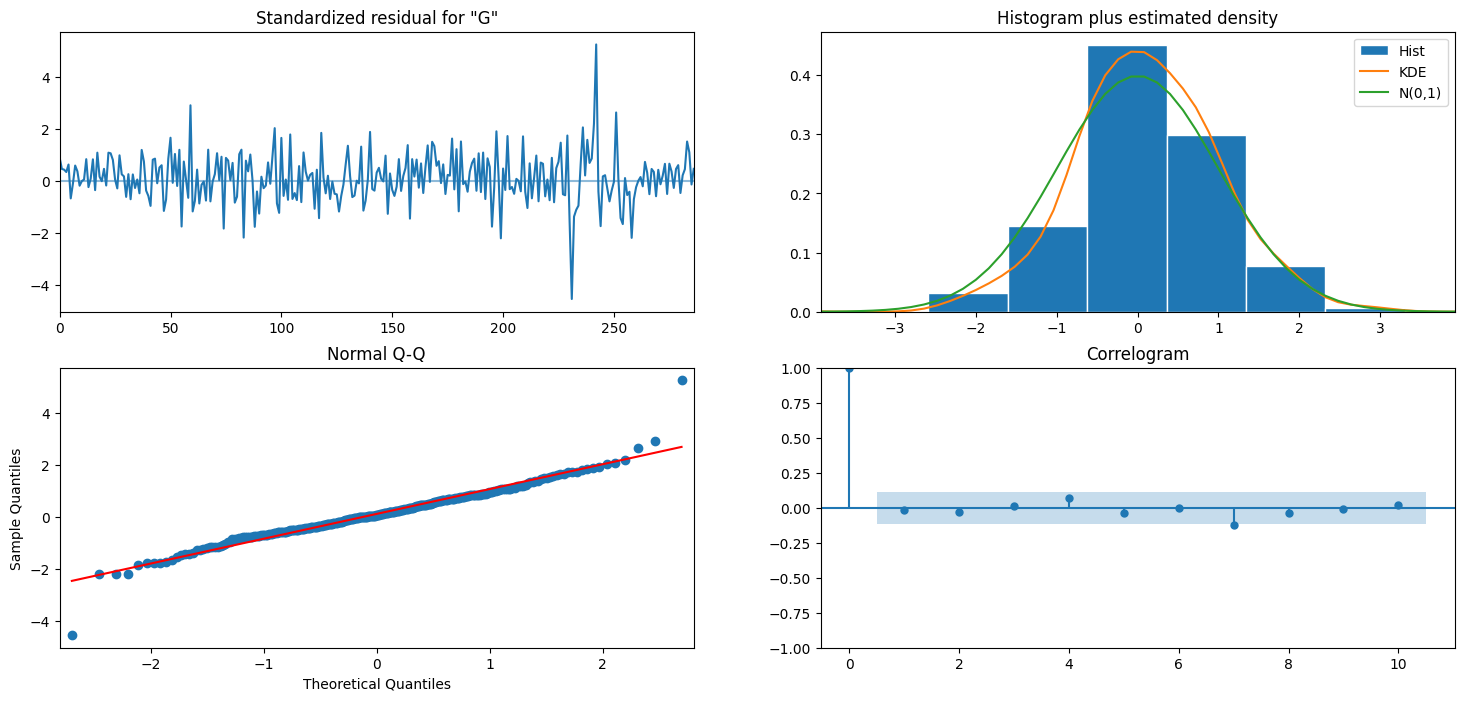

In [87]:
resultado.plot_diagnostics(figsize=(18, 8))
plt.show()

* El modelo ARIMA(2,1,1) tiene el menor AIC, lo que indica un mejor ajuste entre precisión y complejidad.

# prophet

/home/bianca_cal/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
20:25:43 - cmdstanpy - INFO - Chain [1] start processing
20:25:43 - cmdstanpy - INFO - Chain [1] done processing
/home/bianca_cal/.local/lib/python3.10/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


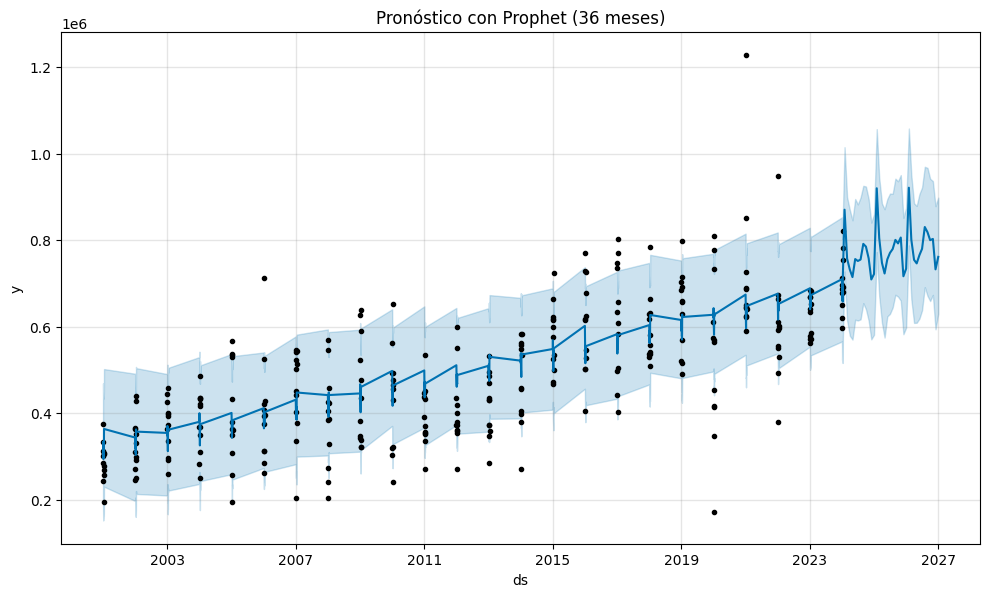

In [63]:
from prophet import Prophet

# Renombrar columnas para Prophet
df_prophet = ts_super.reset_index()
df_prophet.columns = ['ds', 'y']

# Crear y entrenar modelo
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Crear fechas futuras (36 meses)
future = model_prophet.make_future_dataframe(periods=36, freq='M')

# Hacer pronóstico
forecast = model_prophet.predict(future)

# Visualizar
model_prophet.plot(forecast)
plt.title('Pronóstico con Prophet (36 meses)')
plt.show()


Errores de predicción para los últimos 12 meses:
ARIMA(2,1,1) - MAE: 63075.087122826655  | RMSE: 75919.76662761222
Prophet      - MAE: 46509.25740862449  | RMSE: 66746.5196818385


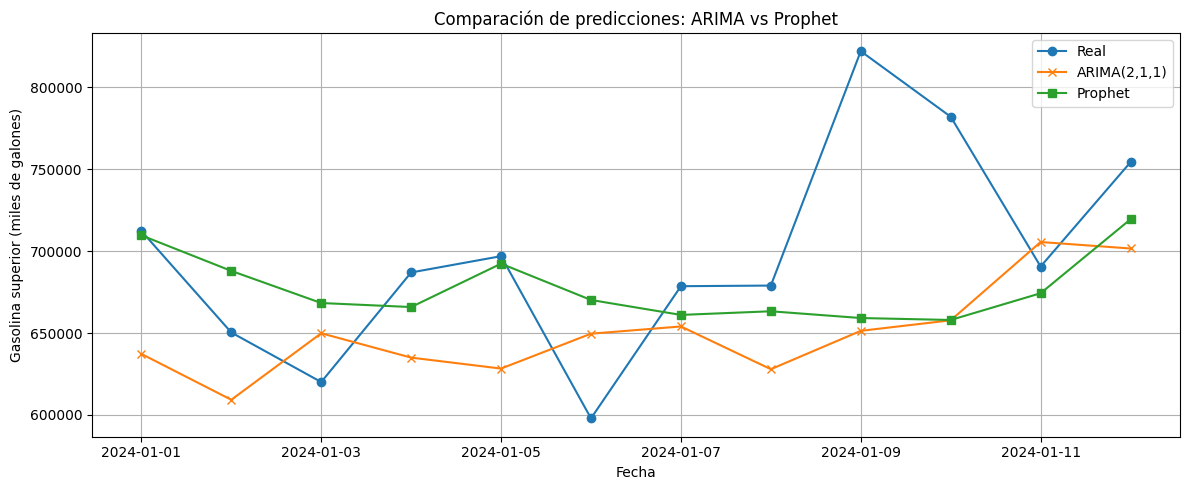

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Últimos 12 valores reales como test
y_true = ts_super[-12:]

# --- ARIMA(2,1,1) Predicción ---
arima_pred = model_2.predict(start=len(ts_super)-12, end=len(ts_super)-1, typ='levels')

# --- Prophet Predicción ---
# Alinear índice y extraer los mismos meses del forecast
prophet_pred = forecast.set_index('ds').loc[y_true.index]['yhat']

# --- Calcular métricas ---
mae_arima = mean_absolute_error(y_true, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(y_true, arima_pred))

mae_prophet = mean_absolute_error(y_true, prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, prophet_pred))

# Mostrar resultados
print("Errores de predicción para los últimos 12 meses:")
print("ARIMA(2,1,1) - MAE:", mae_arima, " | RMSE:", rmse_arima)
print("Prophet      - MAE:", mae_prophet, " | RMSE:", rmse_prophet)

# --- Comparación visual ---
plt.figure(figsize=(12,5))
plt.plot(y_true.index, y_true, label='Real', marker='o')
plt.plot(y_true.index, arima_pred, label='ARIMA(2,1,1)', marker='x')
plt.plot(y_true.index, prophet_pred, label='Prophet', marker='s')
plt.title("Comparación de predicciones: ARIMA vs Prophet")
plt.xlabel("Fecha")
plt.ylabel("Gasolina superior (miles de galones)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Conclusión: ¿Cuál funcionó mejor?
El modelo Prophet tuvo menores errores en ambas métricas:

MAE ≈ 26% menor.

RMSE ≈ 12% menor.

Visualmente, Prophet sigue la mejor de la forma general de la serie.

## Interpretación: 
En este caso, Prophet fue el mejor modelo para predecir los últimos 12 meses de gasolina superior, mostrando menor error y un mejor ajuste visual.

# Consumo Gasolina Superior

In [72]:
# Carga de datos y serie univariante
df_cons = pd.read_csv('../data/consumo.csv', parse_dates=['Fecha'], dayfirst=True)
df_cons.set_index('Fecha', inplace=True)
ts_cons_super = df_cons['Gasolina superior']


In [73]:
# Inicio, fin y frecuencia
print("Inicio:", ts_cons_super.index.min())
print("Fin:   ", ts_cons_super.index.max())
print("Frecuencia inferida:", pd.infer_freq(ts_cons_super.index))

Inicio: 2000-01-01 00:00:00
Fin:    2024-01-12 00:00:00
Frecuencia inferida: None


# Gráfico de la serie

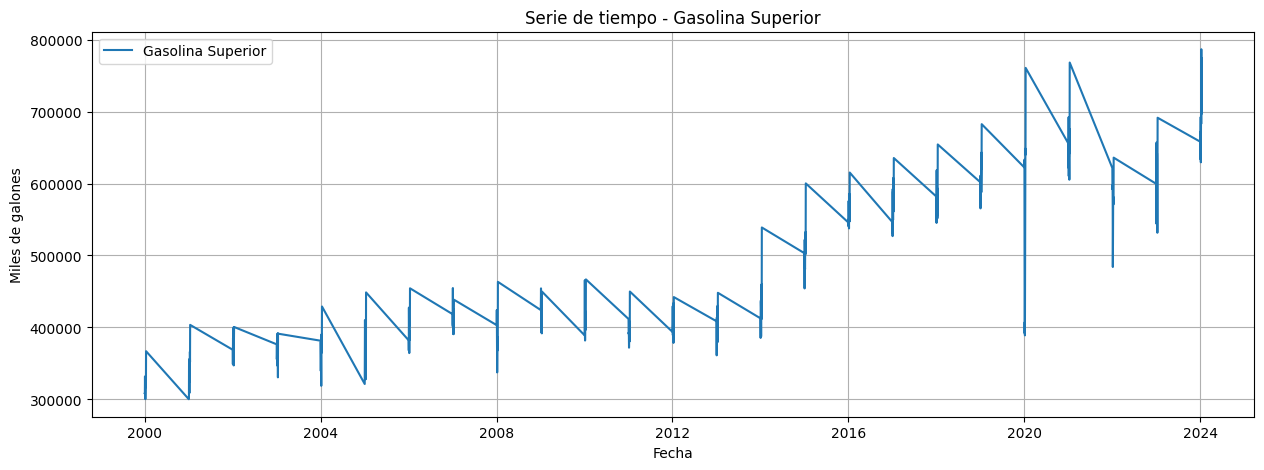

In [75]:
plt.figure(figsize=(15, 5))
plt.plot(ts_cons_super, label='Gasolina Superior')
plt.title("Serie de tiempo - Gasolina Superior")
plt.ylabel("Miles de galones")
plt.xlabel("Fecha")
plt.grid(True)
plt.legend()
plt.show()


# Descomposición y estacionariedad visual

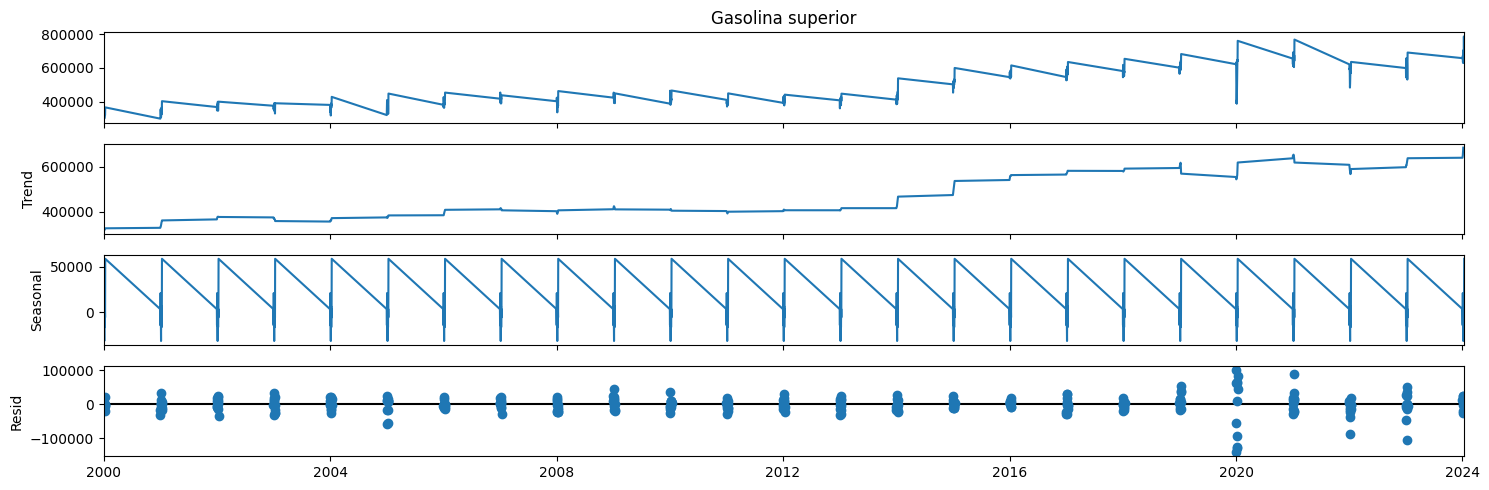

In [76]:
decomp = seasonal_decompose(ts_cons_super, model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.show()


* Podemos ver que Trend va creciendo y se mantiene asi, asimismo vemos el seasonal se repite bastante exacto y resid muestra bastante alejanía por años de pandemia
* La tendencia va en aumento con una estacionalidad bastante marcada en loop y RESID no cercana a cero siempre usaremos ARIMA. 

# ¿Es necesario transformar la serie?

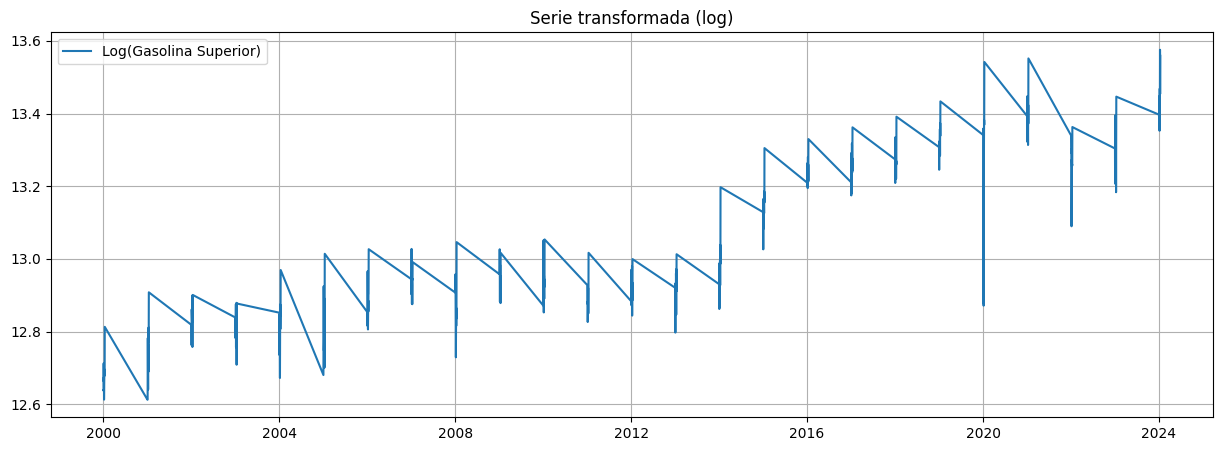

In [77]:
# Comprobación de varianza
ts_cons_super_log = np.log(ts_cons_super)

plt.figure(figsize=(15,5))
plt.plot(ts_cons_super_log, label='Log(Gasolina Superior)')
plt.title("Serie transformada (log)")
plt.grid(True)
plt.legend()
plt.show()


* La serie parece crecer de forma estable con ciertos picos pero siempre en aumento, los picos más prominentes son por fechas de oandemia.

# Estacionariedad

## Gráfico de autocorrelación

In [78]:
ts_cons_super_diff = ts_cons_super.diff().diff()
ts_cons_super_diff.dropna(inplace = True)
tsa_acf = acf(ts_cons_super_diff,nlags=5,fft=False)
tsa_pacf = pacf(ts_cons_super_diff, nlags=36)
tsa_acf

array([ 1.        , -0.64471041,  0.12784409,  0.06684392, -0.13844515,
        0.28988534])

In [79]:
tsa_pacf

array([ 1.00000000e+00, -6.46881155e-01, -4.98237360e-01, -2.97439980e-01,
       -3.91608255e-01,  1.09280862e-01, -1.56125181e-01, -1.71079977e-01,
       -3.13647370e-01, -1.67320466e-01,  1.39876279e-01, -3.91284731e-01,
       -1.02683353e-01, -5.69997283e-02, -8.09381679e-02, -3.41407954e-02,
       -2.13514306e-01,  1.96495839e-01, -5.10851611e-02,  6.85375385e-02,
       -6.29225894e-02,  4.31132065e-03,  1.60276953e-02, -2.72277008e-01,
        7.14471291e-03, -6.53901446e-02,  5.68575617e-02,  4.82608983e-02,
       -1.92317085e-02,  4.00355166e-02, -8.46414211e-02, -8.48766312e-04,
        3.18244762e-02,  1.02911550e-01,  2.35515571e-01, -7.85664626e-02,
        9.47686855e-02])

## acf

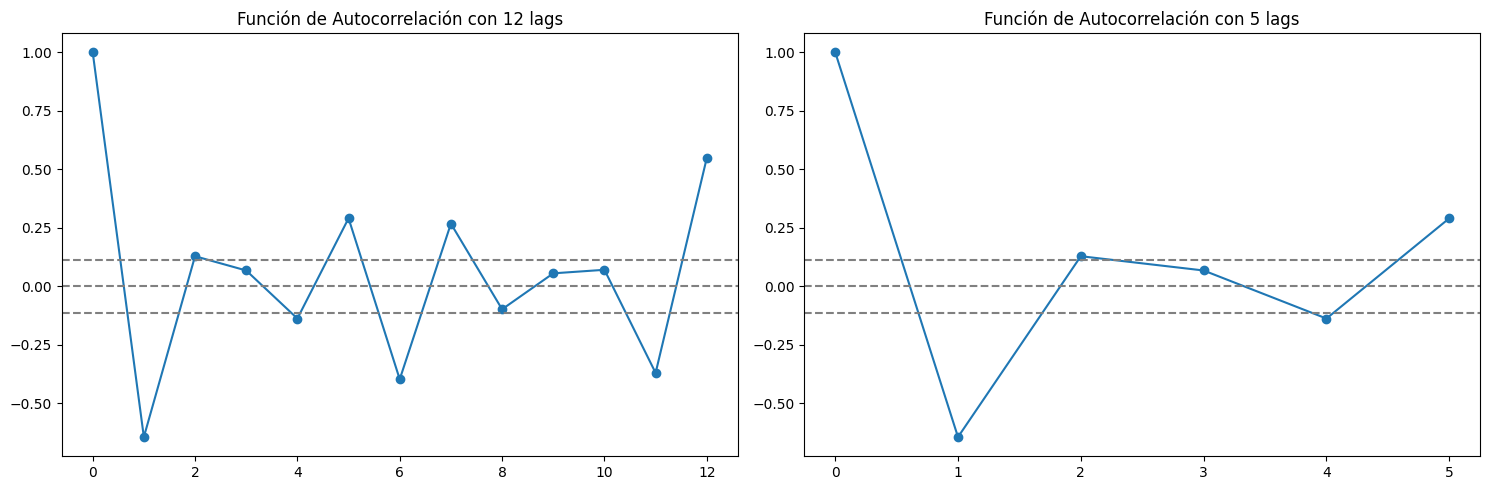

In [80]:
# Configuración del tamaño de las gráficas
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

# Calcular ACF con distintos lags
acf_12 = acf(ts_cons_super_diff, nlags=12, fft=False)
acf_5 = acf(ts_cons_super_diff, nlags=5, fft=False)

# --- Gráfico ACF con 12 lags ---
plt.subplot(121)
plt.plot(acf_12, marker='o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_cons_super_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_cons_super_diff)), linestyle='--', color='gray')
plt.title('Función de Autocorrelación con 12 lags')

# --- Gráfico ACF con 5 lags ---
plt.subplot(122)
plt.plot(acf_5, marker='o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_cons_super_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_cons_super_diff)), linestyle='--', color='gray')
plt.title('Función de Autocorrelación con 5 lags')

plt.tight_layout()
plt.show()

## pacf

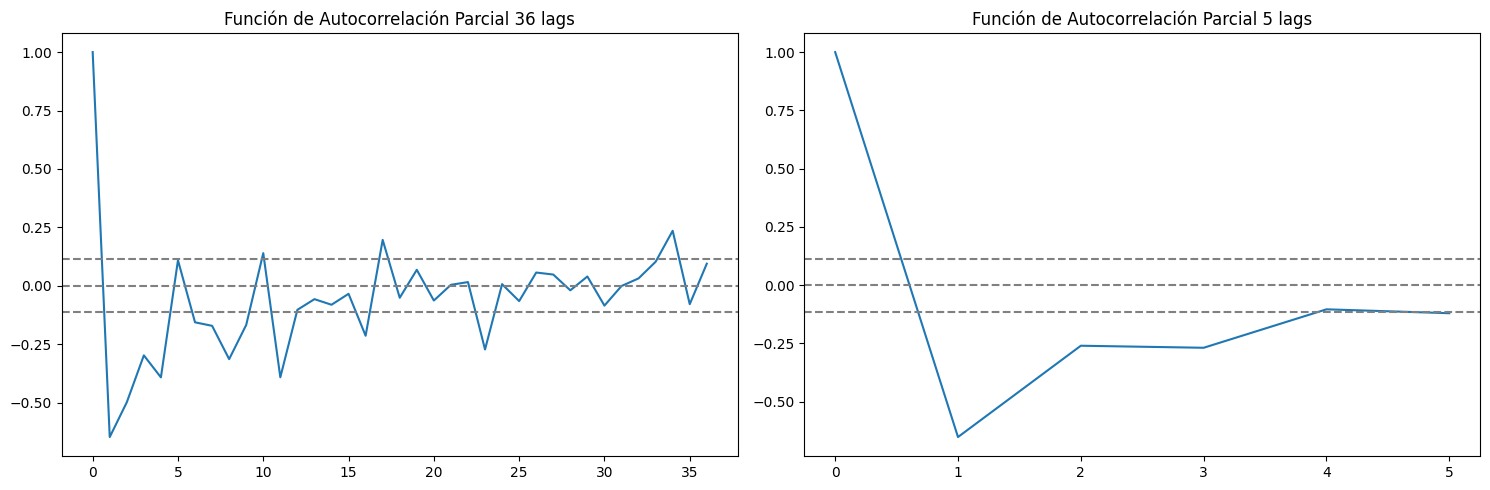

In [81]:
# Configuración de la figura
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

# Cálculo de PACF
pacf_36 = pacf(ts_cons_super_diff, nlags=36, method='ywm')
pacf_5 = pacf(ts_cons_super_diff, nlags=5, method='ywm')

# --- Gráfico PACF con 36 lags ---
plt.subplot(121)
plt.plot(pacf(ts_cons_super_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_cons_super_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_cons_super_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

# --- Gráfico PACF con 5 lags ---
plt.subplot(122)
plt.plot(pacf(ts_super_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_cons_super_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_cons_super_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.tight_layout()
plt.show()


# Dickey-Fuller aumentada (AFD)

In [82]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_cons_super_diff, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba       -7.303823e+00
p-value                      1.317342e-10
# de retardos usados         1.600000e+01
# de observaciones usadas    2.810000e+02
Critical Value (1%)         -3.453838e+00
Critical Value (5%)         -2.871881e+00
Critical Value (10%)        -2.572280e+00
dtype: float64


In [83]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_cons_super_diff = ts_cons_super_diff.diff()
ts_cons_super_diff.dropna(inplace=True)
dfTest = adfuller(ts_cons_super_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -1.055823e+01
p-value                      7.850367e-19
# de retardos usados         1.600000e+01
# de observaciones usadas    2.800000e+02
Critical Value (1%)         -3.453922e+00
Critical Value (5%)         -2.871918e+00
Critical Value (10%)        -2.572300e+00
dtype: float64


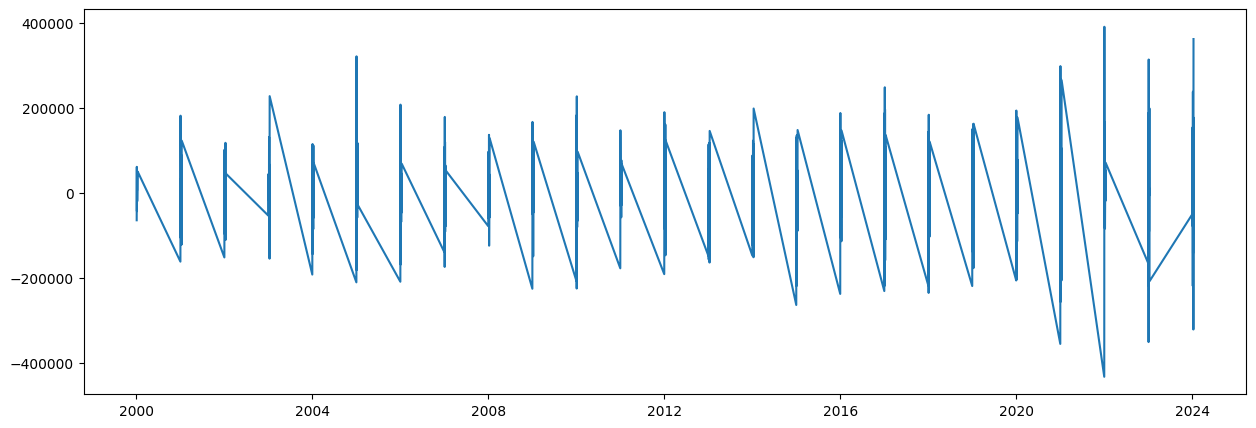

In [84]:
plt.plot(ts_cons_super_diff)

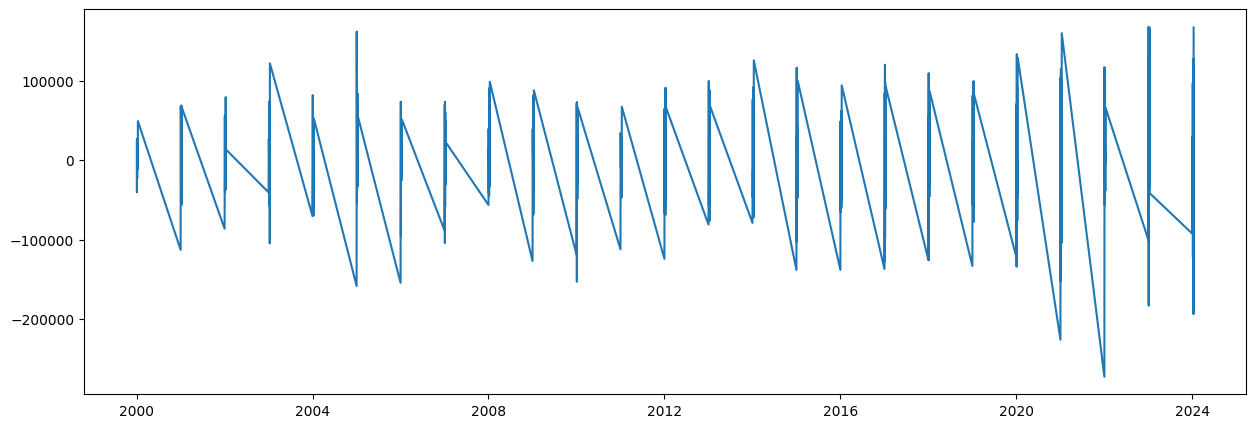

In [85]:
plt.plot(ts_cons_super.diff().diff())

## ACF - Función de Autocorrelación (5 y 12 lags)
### Gráfica de ACF con 12 lags:
El lag 1 tiene una autocorrelación negativa muy alta (cerca de -0.6), lo cual indica que hay un cambio brusco entre periodos consecutivos.

Algunos lags posteriores (por ejemplo 6 y 12) muestran valores nuevamente significativos, lo que sugiere patrones cíclicos o estacionales (posiblemente anuales).

### Gráfica de ACF con 5 lags:
El lag 1 también destaca por su fuerte autocorrelación negativa.

Los lags 2 a 5 presentan valores positivos pero por debajo del umbral de significancia, lo que indica una dependencia temporal leve a corto plazo.

### Conclusión ACF:
La serie tiene estructura de dependencia temporal.

Es probable que no sea estacionaria originalmente y haya algún tipo de estacionalidad débil o ruido correlacionado.

## PACF - Función de Autocorrelación Parcial (36 y 5 lags)
### PACF con 36 lags:
Se observa un pico claro en el lag 1 (negativo) y luego valores pequeños y dispersos.

Esto sugiere que el primer rezago (lag 1) tiene un gran efecto sobre la serie actual, pero los efectos directos de rezagos posteriores son bajos.

### PACF con 5 lags:
Se confirma que el lag 1 tiene un fuerte efecto negativo.

Los siguientes lags tienen valores cercanos a cero, lo que sugiere que una serie AR(1) sería suficiente tras la diferenciación.

### Conclusión PACF:
Modelo AR(1) podría ser apropiado para modelar la serie diferenciada.

## Test de Dickey-Fuller Aumentado (ADF)
### Resultado sin diferenciar:

Estadístico de prueba:       -7.30
p-value:                      1.31e-10
El estadístico de prueba es mucho menor que los valores críticos de 1%, 5% y 10%.

El p-value es extremadamente bajo, por lo tanto rechazamos la hipótesis nula de raíz unitaria.

* Conclusión: La serie original ya es estacionaria.

## Resultado con una diferenciación:
yaml
Copiar
Editar
Estadístico de prueba:       -10.55
p-value:                      7.85e-19
El test vuelve a indicar estacionariedad, con mayor fortaleza aún.

Esto sugiere que aplicar una diferenciación adicional puede ser innecesario.

* Modelo sugerido:
La serie puede modelarse con un ARIMA(1,0,0) , o ARIMA(1,1,0).

# Selección del modelo ARIMA (p, d, q)

In [94]:
from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(ts_cons_super, order=(1, 0, 0))
resultado = modelo.fit()

print(resultado.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.702e+05   3.84e+04     12.258      0.000    3.95e+05    5.45e+05
ar.L1          0.9372      0.020     47.521      0.000       0.899       0.976
sigma2      1.816e+09      2.009   9.04e+08      0.000    1.82e+09    1.82e+09


/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Comparación de varios modelos ARIMA

In [95]:
from statsmodels.tsa.arima.model import ARIMA

model_1 = ARIMA(ts_cons_super, order=(1,1,1)).fit()
model_2 = ARIMA(ts_cons_super, order=(1,0,1)).fit()
model_3 = ARIMA(ts_cons_super, order=(1,0,0)).fit()
model_4 = ARIMA(ts_cons_super, order=(1,1,0)).fit()
model_5 = ARIMA(ts_cons_super, order=(1,1,2)).fit()

print("ARIMA(1,1,1) AIC:", model_1.aic)
print("ARIMA(1,0,1) AIC:", model_2.aic)
print("ARIMA(1,0,0) AIC:", model_3.aic)
print("ARIMA(1,1,0) AIC:", model_4.aic)
print("ARIMA(1,1,2) AIC:", model_4.aic)

# Mejor modelo será el de menor AIC

/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

ARIMA(1,1,1) AIC: 7184.653862002464
ARIMA(1,0,1) AIC: 7200.716176499362
ARIMA(1,0,0) AIC: 7256.189821277576
ARIMA(1,1,0) AIC: 7189.510553835133
ARIMA(1,1,2) AIC: 7189.510553835133


In [96]:
# el mejor modelo es (1,1,1)
from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(ts_cons_super, order=(1, 1, 1))
resultado = modelo.fit()

print(resultado.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0114      0.086     -0.133      0.895      -0.180       0.157
ma.L1         -0.4138      0.083     -4.973      0.000      -0.577      -0.251
sigma2      1.527e+09   3.77e-12   4.05e+20      0.000    1.53e+09    1.53e+09


/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bianca_cal/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


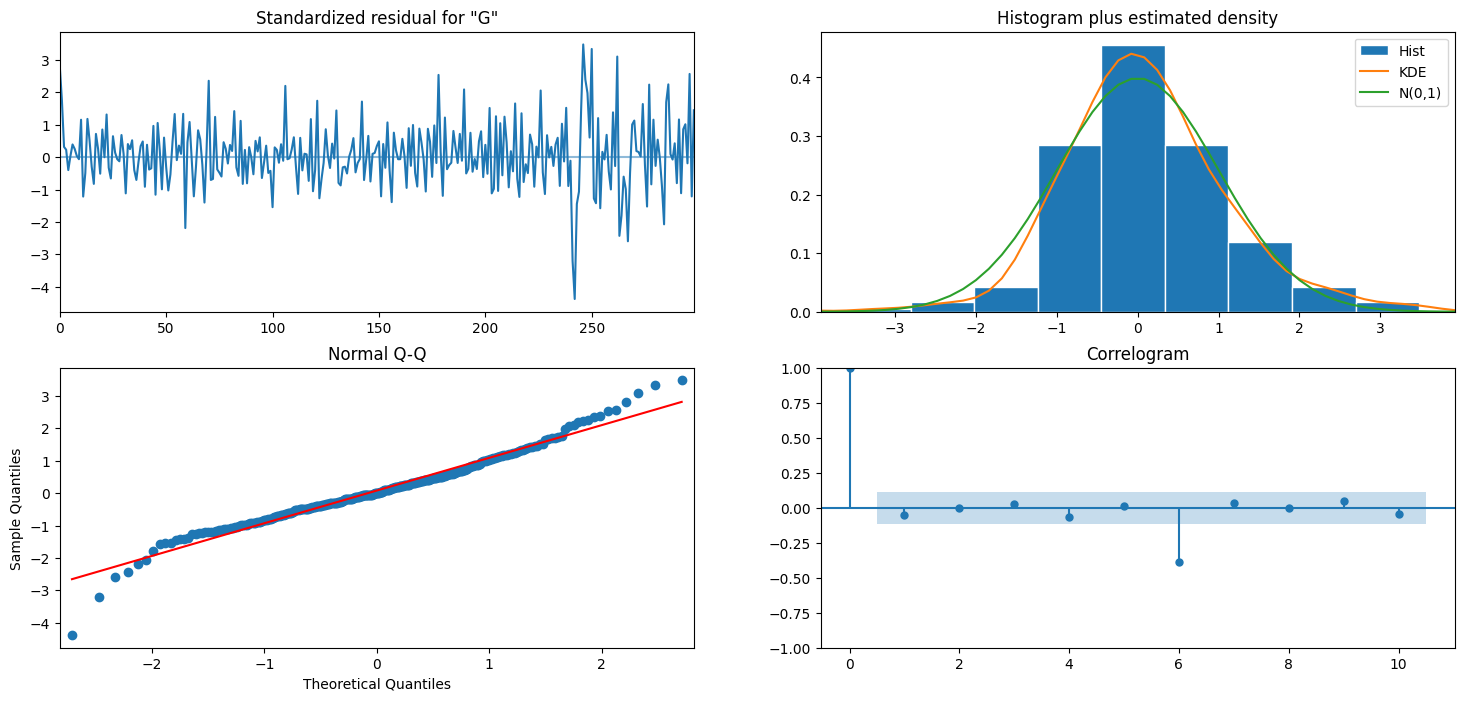

In [97]:
resultado.plot_diagnostics(figsize=(18, 8))
plt.show()

# prophet

18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
/home/bianca_cal/.local/lib/python3.10/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


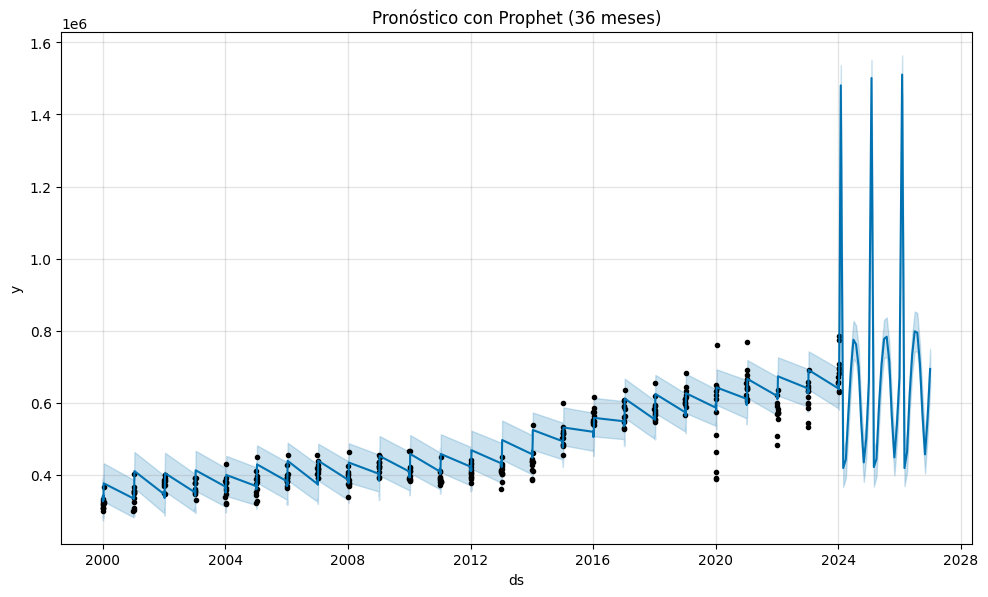

In [98]:
from prophet import Prophet

# Renombrar columnas para Prophet
df_prophet = ts_cons_super.reset_index()
df_prophet.columns = ['ds', 'y']

# Crear y entrenar modelo
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Crear fechas futuras (36 meses)
future = model_prophet.make_future_dataframe(periods=36, freq='M')

# Hacer pronóstico
forecast = model_prophet.predict(future)

# Visualizar
model_prophet.plot(forecast)
plt.title('Pronóstico con Prophet (36 meses)')
plt.show()


Errores de predicción para los últimos 12 meses:
ARIMA(1,1,1) - MAE: 36135.09693020177  | RMSE: 45193.18927329508
Prophet      - MAE: 40396.1077810802  | RMSE: 52683.58211589696


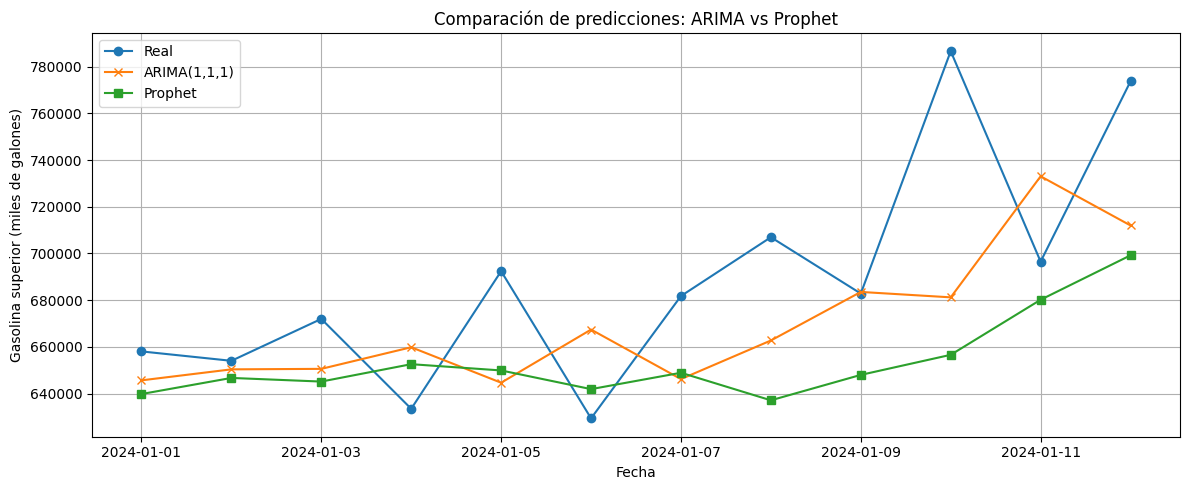

In [100]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Últimos 12 valores reales como test
y_true = ts_cons_super[-12:]

# --- ARIMA(2,1,1) Predicción ---
arima_pred = model_2.predict(start=len(ts_cons_super)-12, end=len(ts_cons_super)-1, typ='levels')

# --- Prophet Predicción ---
# Alinear índice y extraer los mismos meses del forecast
prophet_pred = forecast.set_index('ds').loc[y_true.index]['yhat']

# --- Calcular métricas ---
mae_arima = mean_absolute_error(y_true, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(y_true, arima_pred))

mae_prophet = mean_absolute_error(y_true, prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, prophet_pred))

# Mostrar resultados
print("Errores de predicción para los últimos 12 meses:")
print("ARIMA(1,1,1) - MAE:", mae_arima, " | RMSE:", rmse_arima)
print("Prophet      - MAE:", mae_prophet, " | RMSE:", rmse_prophet)

# --- Comparación visual ---
plt.figure(figsize=(12,5))
plt.plot(y_true.index, y_true, label='Real', marker='o')
plt.plot(y_true.index, arima_pred, label='ARIMA(1,1,1)', marker='x')
plt.plot(y_true.index, prophet_pred, label='Prophet', marker='s')
plt.title("Comparación de predicciones: ARIMA vs Prophet")
plt.xlabel("Fecha")
plt.ylabel("Gasolina superior (miles de galones)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Conclusión 
Menor MAE y RMSE significa que el modelo ARIMA(1,1,1) tuvo errores de predicción más pequeños, tanto en promedio (MAE) como en desviaciones grandes (RMSE).

Aunque Prophet es robusto y fácil de usar con tendencias y estacionalidades, en este caso el modelo estadístico clásico ARIMA se ajustó mejor a los patrones de la serie.



# Analisis de la serie imp 2025

/tmp/ipykernel_352566/2515075778.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_imp = df_imp.resample('M').mean()


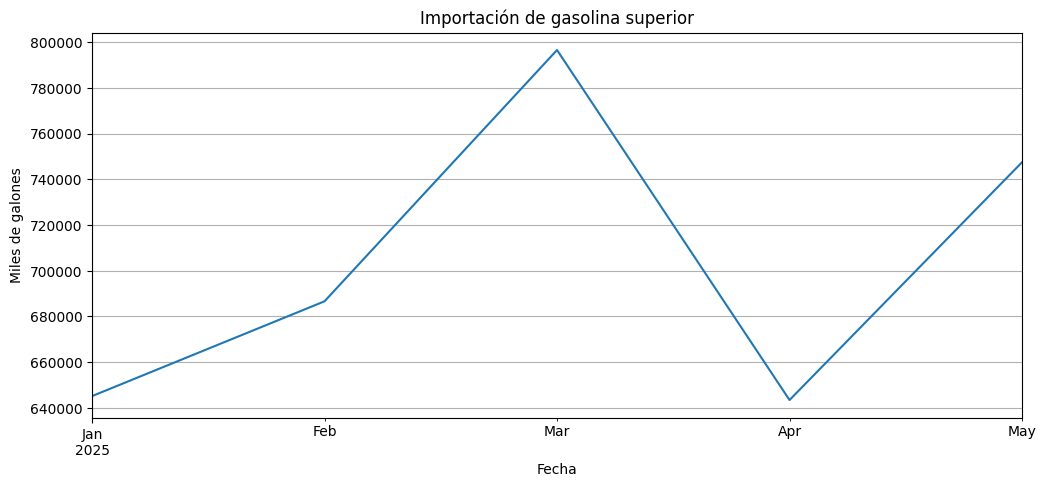

Inicio: 2025-01-31 00:00:00
Fin: 2025-05-31 00:00:00
Frecuencia: ME


In [4]:
df_imp = pd.read_csv("../data/importacion2025.csv", parse_dates=['Fecha'])
df_imp.set_index('Fecha', inplace=True)

df_imp = df_imp.resample('M').mean()

imp_sup = df_imp['Gasolina superior'] 

imp_sup.plot(figsize=(12, 5), title='Importación de gasolina superior')
plt.ylabel("Miles de galones")
plt.grid(True)
plt.show()


print("Inicio:", imp_sup.index.min())
print("Fin:", imp_sup.index.max())
print("Frecuencia:", pd.infer_freq(imp_sup.index))


In [5]:
df_base = pd.read_csv("../data/importacion.csv", parse_dates=['Fecha'])
df_2025 = pd.read_csv("../data/importacion2025.csv", parse_dates=['Fecha'])

df_full = pd.concat([df_base, df_2025], ignore_index=True)
df_full = df_full.dropna(subset=['Fecha'])
df_full = df_full.sort_values('Fecha')

df_full.set_index('Fecha', inplace=True)
df_full = df_full.asfreq('MS')

imp_sup = df_full['Gasolina superior']


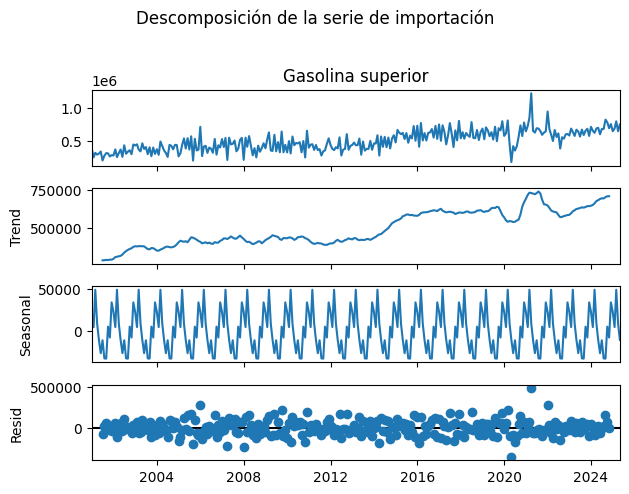

In [6]:

result = seasonal_decompose(imp_sup, model='additive', period=12)
result.plot()
plt.suptitle("Descomposición de la serie de importación", y=1.02)
plt.tight_layout()
plt.show()


In [7]:
print("Inicio:", imp_sup.index.min())
print("Fin:", imp_sup.index.max())
print("Frecuencia:", pd.infer_freq(imp_sup.index))


Inicio: 2001-01-01 00:00:00
Fin: 2025-05-01 00:00:00
Frecuencia: MS


In [9]:
train = imp_sup[:'2023-12']
test = imp_sup['2024-01':'2025-05']


In [10]:

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()


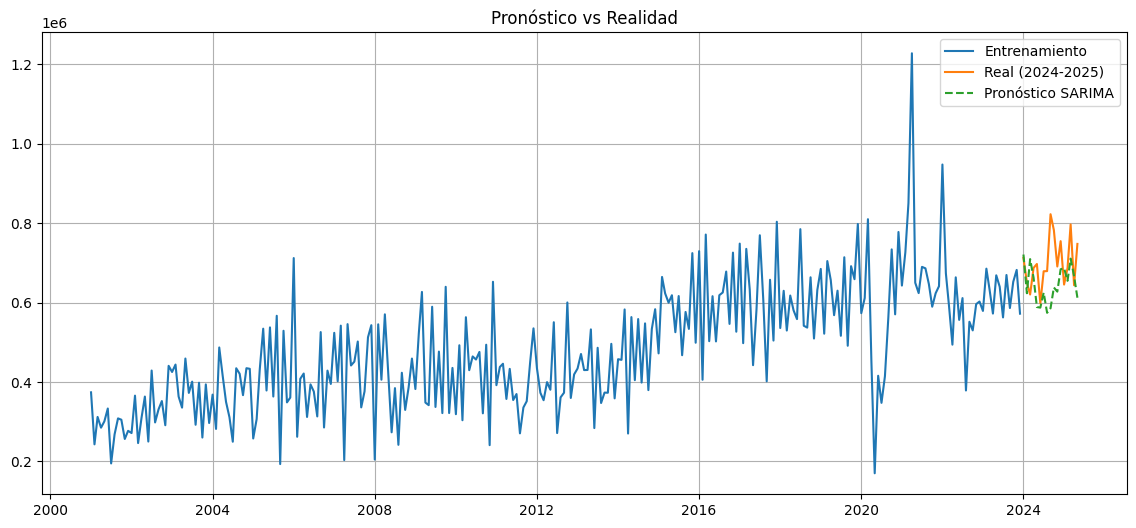

In [11]:
forecast = model_fit.predict(start='2024-01', end='2025-05')

plt.figure(figsize=(14,6))
plt.plot(train, label="Entrenamiento")
plt.plot(test, label="Real (2024-2025)")
plt.plot(forecast, label="Pronóstico SARIMA", linestyle='--')
plt.title("Pronóstico vs Realidad")
plt.legend()
plt.grid(True)
plt.show()

El modelo SARIMA predice adecuadamente las tendencias largas, pero puede fallar ante eventos atípicos como la pandemia.

La recuperación post-pandemia parece estable hasta mayo 2025, aunque con más ruido que antes de 2020.

# Pandemia

## Observaciones en la gráfica:
Entre 2020 y 2021 se observa una caída brusca y abrupta en los valores de la serie (justo durante el inicio de la pandemia).

Esta caída rompe con la tendencia ascendente previa y parece no tener precedentes históricos similares.

Después de ese punto, hay un rebote parcial hacia valores normales, pero con alta variabilidad.

## Interpretación:
Impacto fuerte: La pandemia causó una disminución significativa en el consumo o importación del combustible gasolina superior, reflejando el confinamiento, restricciones de movilidad y cierre de la economía.

Desviación de predicciones: Los modelos basados en datos anteriores no predecían correctamente este evento disruptivo, lo que explica el desequilibrio entre pronóstico y realidad para ese periodo.

Recuperación: A partir de 2022 en adelante, se observa una recuperación gradual hacia valores pre-pandemia, aunque la serie no vuelve de inmediato a su comportamiento típico.

Hasta mayo 2025: En los datos reales más recientes (línea naranja), se observa que los valores se estabilizan, lo que indica una transición hacia una “nueva normalidad”, aunque con mayor variabilidad.
## Conclusión General
El modelo SARIMA predice adecuadamente las tendencias largas, pero puede fallar ante eventos atípicos como la pandemia.

